In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.grid_search import GridSearchCV
from sklearn import metrics

# set random state to use throughout
rs = 25

In [2]:
# import data and format it
data = pd.read_csv('../Data/gss_subset_cleaned.csv')
data = data[data['year']> 2005]
# drop highly correlated columns and unusable columns identified in earlier analysis
data.drop(['paeduc', 'maeduc', 'speduc', 'income', 'satjob', 'goodlife', 
           'health', 'year', 'hompop', 'earnrs'], axis=1, inplace=True)
# drop less important features from first run-through of RF
data.drop(['babies', 'preteen', 'teens', 'divorce', 'dwelling', 'sex', 'hhrace'], axis=1, inplace=True)
# drop NA
data1 = data.dropna()

In [3]:
data1.columns

Index([u'marital', u'sibs', u'childs', u'age', u'educ', u'adults', u'polviews',
       u'happy', u'weekswrk', u'satfin', u'dwelown'],
      dtype='object')

In [4]:
# set X and y
X = pd.get_dummies(data1.drop('happy', axis=1), drop_first=True)
y = data1['happy'] == 1 # y is "true" when individual is unhappy

In [5]:
# look at % in each class
y.value_counts()/y.count()

False    0.861305
True     0.138695
Name: happy, dtype: float64

In [6]:
# do train_test split
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y,
        stratify = y, test_size=0.2, random_state=rs)

In [7]:
# instantiate Random Forest
rf = RandomForestClassifier(random_state=rs, n_jobs=-1)

In [8]:
# define param grid for gridsearch
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [15,18,21],
    'n_estimators': [15,18],
    'min_samples_split': [30,40,50],
    'min_samples_leaf': [5,10,20],
    'max_features': [5,10,'auto']
}

In [9]:
# instantiate gridsearch for random forest
gsrf = GridSearchCV(rf, param_grid, n_jobs=-1, scoring = 'roc_auc')

## Run and Evaluate Model on Fuller Training Set (including subjective features that would need to be assessed in interview)

In [10]:
# fit GS RF on training data, print best estimator and out-of-sample score
gsrf.fit(X1_train, y1_train)
print gsrf.best_estimator_
print gsrf.best_score_
print gsrf.score(X1_test, y1_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=20, min_samples_split=30,
            min_weight_fraction_leaf=0.0, n_estimators=18, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)
0.749405916065
0.758799564167


/Users/caitlingerrity/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:418: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


In [11]:
# Calculate prediction probabilities, use threshold of 15% to classify as unhappy
gsrf_proba1 = gsrf.predict_proba(X1_test)
gsrf_pred1 = gsrf_proba1[:,1] > 0.15
print classification_report(y1_test, gsrf_pred1)
print confusion_matrix(y1_test, gsrf_pred1)

             precision    recall  f1-score   support

      False       0.93      0.69      0.80      1881
       True       0.27      0.70      0.39       303

avg / total       0.84      0.69      0.74      2184

[[1304  577]
 [  92  211]]


In [12]:
# look at relative importance of different features
features = X1_train.columns
importances = gsrf.best_estimator_.feature_importances_
feat_importances = pd.DataFrame(index=features, columns = ['importance'])
feat_importances['importance'] = importances
feat_importances.sort_values(by='importance', ascending = False).round(decimals=3)

,importance
satfin,0.314
educ,0.111
age,0.103
weekswrk,0.089
marital_married,0.088
sibs,0.073
adults,0.045
polviews,0.042
dwelown_owns,0.041
childs,0.039


## Run and Evaluate Model on More Realistic Training Set (including only demographic/biographic information)

In [26]:
# drop subjective features
data.drop(['satfin', 'weekswrk', 'polviews'],axis=1, inplace=True)

#drop NA
data2 = data.dropna()
# set X and y
X = pd.get_dummies(data2.drop('happy', axis=1), drop_first=True)
y = data2['happy'] == 1 # y is "true" when individual is unhappy

# look at % in each class
y.value_counts()/y.count()

False    0.857693
True     0.142307
Name: happy, dtype: float64

In [14]:
# do train_test split
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y,
        stratify = y, test_size=0.2, random_state=rs)

In [15]:
# fit GS RF and print best estimator, out-of-sample score
gsrf.fit(X2_train, y2_train)
print gsrf.best_estimator_
print gsrf.best_score_
print gsrf.score(X2_test, y2_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=20, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)
0.698736827227
0.681594947633


In [16]:
# Calculate prediction probabilities, use threshold of 15% to classify as unhappy
gsrf_proba2 = gsrf.predict_proba(X2_test)
gsrf_pred2 = gsrf_proba2[:,1] > 0.15
print classification_report(y2_test, gsrf_pred2)
print confusion_matrix(y2_test, gsrf_pred2)

             precision    recall  f1-score   support

      False       0.91      0.60      0.73      1961
       True       0.21      0.65      0.32       325

avg / total       0.81      0.61      0.67      2286

[[1181  780]
 [ 113  212]]


In [17]:
# look at relative importance of different features
features = X2_train.columns
importances = gsrf.best_estimator_.feature_importances_
feat_importances = pd.DataFrame(index=features, columns = ['importance'])
feat_importances['importance'] = importances
feat_importances.sort_values(by='importance', ascending = False).round(decimals=3)

,importance
educ,0.221
marital_married,0.208
age,0.172
sibs,0.111
childs,0.074
dwelown_owns,0.071
adults,0.054
dwelown_rents,0.040
marital_separated,0.019
marital_never_married,0.018


## Look at ROC curves and Model Value-Add

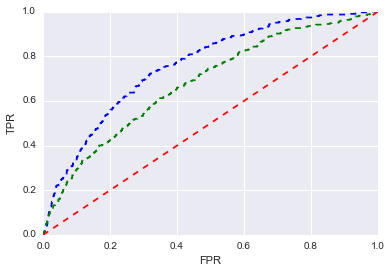

In [18]:
# look at ROC curve for model with more features and less features
fpr1, tpr1, _ = metrics.roc_curve(y1_test, gsrf_proba1[:,1])
fpr2, tpr2, _ = metrics.roc_curve(y2_test, gsrf_proba2[:,1])
plt.plot(fpr1, tpr1, 'b--', fpr2, tpr2, 'g--', fpr1, fpr1, 'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')

In [19]:
# save data as CSV for graphing in Tableau
df1 = pd.DataFrame({'Model': 1, 'FPR': fpr1, 'TPR': tpr1})
df2 = pd.DataFrame({'Model': 2, 'FPR': fpr2, 'TPR': tpr2})
df3 = pd.DataFrame({'Model': 'Baseline', 'FPR': fpr1, 'TPR': fpr1})
df = df1.append(df2, ignore_index=True).append(df3, ignore_index=True)
df = df[['Model', 'FPR', 'TPR']]
df.to_csv('../Data/rf_fpr_tpr.csv', encoding='utf-8', index=False)

In [20]:
def getPlotValueAdd(probas, y_test):
    # create dataframe with the model's predicted P(unhappy) along with boolean for actual unhappiness
    modelprobs = pd.DataFrame()
    modelprobs['Model_Prob_Unhappy'] = probas[:,1]
    modelprobs['Unhappy_True'] = y_test.as_matrix()

    # sort by P(Unhappy) and add columns for % Unhappy and % Happy people falling above that threshold
    modelprobs.sort_values(by='Model_Prob_Unhappy', axis=0, inplace=True, ascending=False)
    modelprobs['portion_unhappy_captured'] = np.cumsum(modelprobs['Unhappy_True'])/np.sum(modelprobs['Unhappy_True'])
    modelprobs['portion_happy_mislabeled'] = np.cumsum(1-modelprobs['Unhappy_True'])/np.sum(1-modelprobs['Unhappy_True'])
    # add column with ratio of correct prediction (ie, precision for predicting unhappiness)
    modelprobs['ratio_correct_prediction'] = np.cumsum(modelprobs['Unhappy_True'])/(np.cumsum(modelprobs['Unhappy_True']) + np.cumsum(1-modelprobs['Unhappy_True']))

    # Plot the difference
    x = modelprobs['Model_Prob_Unhappy']
    y1 = modelprobs['portion_unhappy_captured']
    y2 = modelprobs['portion_happy_mislabeled']
    y3 = modelprobs['ratio_correct_prediction']
    plt.plot(x, y1, 'b--', x, y2, 'r--', x, y3, 'g--')
    
    # return DF
    return modelprobs

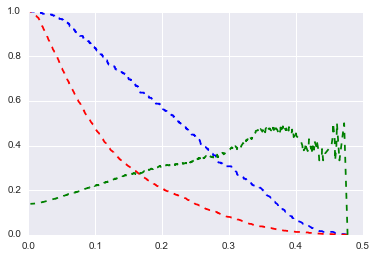

In [21]:
# look at value add for model with more features
modelprobs1 = getPlotValueAdd(gsrf_proba1, y1_test)

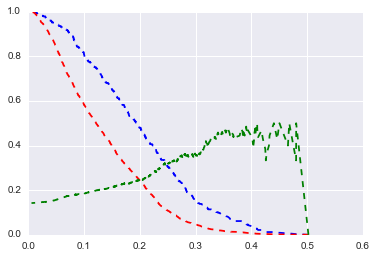

In [22]:
# look at value add for 'more realistic' model
modelprobs2 = getPlotValueAdd(gsrf_proba2, y2_test)

## Save Data for Model FPR vs Recall

In [23]:
melted = pd.melt(modelprobs2, id_vars= ['Model_Prob_Unhappy', 'Unhappy_True'])

In [24]:
melted.to_csv('../Data/rf_proba_test.csv', index=False, encoding='utf-8')